In [99]:
from face_processing import FaceDetector
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from matplotlib import cm

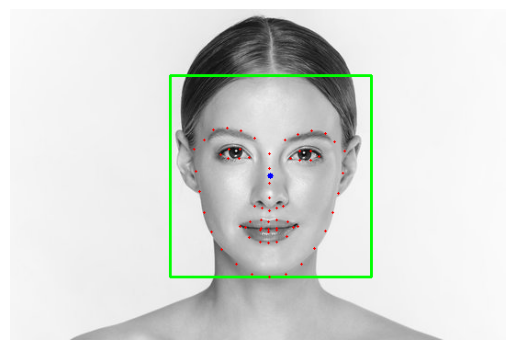

In [100]:
IMAGE_PATH = "test_images/face.jpg"

face_detector = FaceDetector()
img_rgb, _, face_centers, landmarks_all_faces = face_detector.detect(IMAGE_PATH)

face_detector.display(img_rgb)

In [103]:
class MaskHandler:
    def mask_points(self, img_path: str, landmarks: List[np.ndarray]) -> Tuple[np.ndarray, List[List[Tuple[int, int]]]]:
        """
        highlights 7 key landmark points on each face (brow, lips, eyes, nose tip)

        in:
            img_path (str): path to the input image file
            landmarks (List[np.ndarray]): list of 68-point landmark arrays per face

        out:
            img_rgb (np.ndarray): rgb image with selected points drawn
            selected_pts (List[List[Tuple[int, int]]]): per-face list of (x, y) tuples (7 per face)
        """

        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)

        idxs = [18, 25, 48, 54, 36, 45, 51]

        selected_pts: List[List[Tuple[int, int]]] = []
        for lm in landmarks:
            face_pts = []
            for i in idxs:
                x, y = lm[i]
                face_pts.append((int(x), int(y)))
                cv2.circle(img_rgb, (int(x), int(y)), 3, (0, 255, 255), -1)
            selected_pts.append(face_pts)

        return img_rgb, selected_pts

    def display_mask(self, img_path: str, mask_pts: List[List[Tuple[int, int]]]) -> None:
        """
        applies convex polygon masks to the selected facial areas and displays the result

        in:
            img_path (str): path to the input grayscale image
            mask_pts (List[List[Tuple[int, int]]]): list of (x, y) points per face to mask
        """
        
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_original_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

        mask = np.zeros(img_gray.shape, dtype=np.uint8)
        for face_polygon in mask_pts:
            polygon = np.array(face_polygon, dtype=np.int32)
            hull = cv2.convexHull(polygon)
            cv2.fillPoly(mask, [hull], color=255)

        masked_rgb = cv2.bitwise_and(img_original_rgb, img_original_rgb, mask=mask)

        plt.imshow(masked_rgb)
        plt.axis('off')
        plt.show()
    
    def get_intensity_probability_maps(self, img_path: str, mask_pts: List[List[Tuple[int, int]]]) -> Tuple[np.ndarray, List[np.ndarray]]:

        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        prob_maps = []
        colormap = plt.get_cmap('plasma')

        for face_polygon in mask_pts:

            mask = np.zeros(img_gray.shape, dtype=np.uint8)
            polygon = np.array(face_polygon, dtype=np.int32)
            hull = cv2.convexHull(polygon)
            cv2.fillPoly(mask, [hull], 255)

            face_pixels = img_gray[mask == 255]
            if len(face_pixels) == 0:
                prob_maps.append(np.zeros(256))
                continue
            
            hist = cv2.calcHist([face_pixels], [0], None, [256], [0, 256])
            hist_prob = hist / hist.sum()
            prob_maps.append(hist_prob.flatten())

            non_zero_mask = hist_prob > 0
            if np.any(non_zero_mask):
                # Get only non-zero values
                non_zero_values = hist_prob[non_zero_mask]
                
                # Calculate min and max of non-zero values
                min_prob = np.min(non_zero_values)
                max_prob = np.max(non_zero_values)
                
                # Create enhanced version with stretched range
                enhanced_prob = np.zeros_like(hist_prob)
                
                # Apply stretching to non-zero values only
                if max_prob > min_prob:
                    # Linear stretching from 0 to 1
                    enhanced_prob[non_zero_mask] = (hist_prob[non_zero_mask] - min_prob) / (max_prob - min_prob)
                else:
                    # If only one non-zero value exists
                    enhanced_prob[non_zero_mask] = 1.0
            else:
                # Fallback if no non-zero values
                enhanced_prob = hist_prob
                
            # Use enhanced probabilities for coloring
            for intensity in range(256):
                if hist_prob[intensity, 0] > 0:  # Only process non-zero probabilities
                    prob = enhanced_prob[intensity, 0]
                    rgba = colormap(float(prob))
                    
                    r, g, b = [int(255 * c) for c in rgba[:3]]
                    img_rgb[(mask == 255) & (img_gray == intensity)] = [r, g, b]
        
        return img_rgb, prob_maps

    def visualize_probability_histograms(self, prob_maps):
        """
        Visualize only the probability histograms/maps returned from get_intensity_probability_maps.
        
        Parameters:
        - prob_maps: List of probability maps for each mask
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Create a figure with subplots for each probability map
        n_maps = len(prob_maps)
        fig, axes = plt.subplots(n_maps, 1, figsize=(10, 3 * n_maps))
        
        # Handle the case of a single histogram
        if n_maps == 1:
            axes = [axes]
        
        # Plot each probability histogram
        for i, prob_map in enumerate(prob_maps):
            x = np.arange(256)
            axes[i].bar(x, prob_map, color='blue', alpha=0.7)
            axes[i].set_title(f'Probability Distribution - Mask {i+1}')
            axes[i].set_xlabel('Pixel Intensity')
            axes[i].set_ylabel('Probability')
            
            # Add some stats to the plot
            non_zero = prob_map[prob_map > 0]
            if len(non_zero) > 0:
                max_prob = np.max(prob_map)
                mean_intensity = np.sum(x * prob_map) / np.sum(prob_map)
                axes[i].text(0.02, 0.95, f'Max probability: {max_prob:.4f}\nMean intensity: {mean_intensity:.1f}', 
                            transform=axes[i].transAxes, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

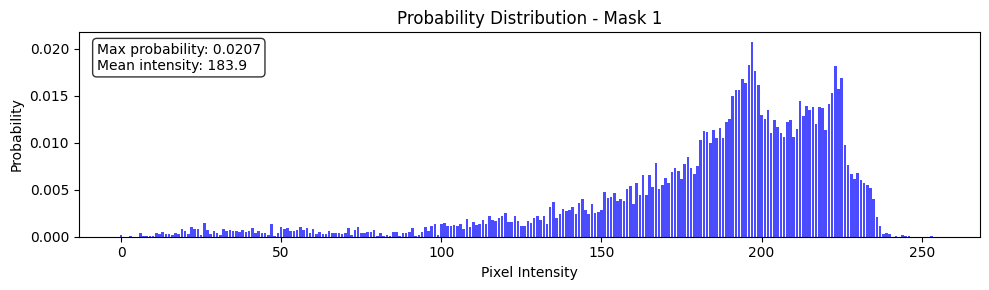

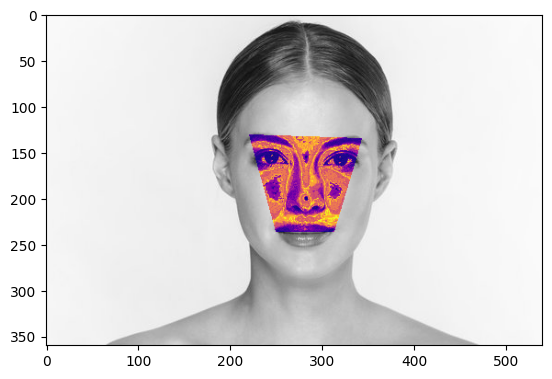

In [106]:
IMAGE_PATH = "test_images/face.jpg"

face_detector = FaceDetector()
img_rgb, _, face_centers, landmarks_all_faces = face_detector.detect(IMAGE_PATH)

mask_handler = MaskHandler()
img_rgb, selected_pts = mask_handler.mask_points(IMAGE_PATH, landmarks_all_faces)

intensity_colored_img, prob_maps = mask_handler.get_intensity_probability_maps(IMAGE_PATH, selected_pts)

mask_handler.visualize_probability_histograms(prob_maps)

plt.imshow(intensity_colored_img)